In [1]:
## 导入包
import numpy as np
import torch
import torch.nn as nn
from torchinfo import summary
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from imblearn.under_sampling import RandomUnderSampler # 多数样本下采样


In [2]:
# 加载数据
data = np.load("./data_processed/data_norm.npy")
labels = np.load("./data_processed/labels.npy")  # 2139个负样本1，其余全是正样本0

In [3]:
# ## 降采样1 随机抽取
# data2 = data.reshape(30502, -1)
# # 降采样策略
# rus = RandomUnderSampler(sampling_strategy = {0: 2139})  # 将正常样本降采样到2139个

# data_resample, labels_resample = rus.fit_resample(data2, labels)

# data_resample = data_resample.reshape(-1, 16, 32, 16) # 恢复原来形状
# print([data_resample.shape, labels_resample.shape])


In [4]:
# 降采样1 手动抽取
nor_id = np.where(labels == 0)[0]
nor_id = nor_id[0:2139]
dram_id = np.where(labels == 1)[0]

In [5]:
data_nor = data[nor_id,:,:,:]
data_dram = data[dram_id,:,:,:]

data_resample = np.append(data_nor, data_dram, axis = 0)
labels_resample = np.append(labels[nor_id], labels[dram_id], axis = 0)


In [6]:
# 残差块
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1): # 指定输入通道，输出通道
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )
            
    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = self.relu(out)
        return out

In [14]:
# 输入是 16x32x16
class ResNet_Encoder(nn.Module):
    def __init__(self, num_classes = 2):
        super(ResNet_Encoder, self).__init__()
        self.conv1 = nn.Conv2d(16, 4, kernel_size=3, stride=1, padding=1) # 输入为16个通道
        self.bn1 = nn.BatchNorm2d(4)
        self.relu = nn.ReLU(inplace = True)
        self.layer1 = self._make_layer(4, 8, 2, stride=2) # 输入通道、输出通道、块数
        self.layer2 = self._make_layer(8, 16, 2, stride=1)
        # self.layer3 = self._make_layer(32, 64, 2, stride=1)
        
        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=16, nhead=8), # 两个参数分别是输入样本的维度(32)和Encoder头的数量(头的数量必须能被维度整除)
            num_layers= 4, # 层数，即最终的Encoder由4个EncoderLayer组成
        ) # 最终transformer_encoder的输入形式是(序列长度，批大小，维度)，输出也还是(序列长度，批大小，维度)，大小都不变
        
        self.fc1 = nn.Linear(16*128, 16)
        self.fc2 = nn.Linear(16, 2)

    def _make_layer(self, in_channels, out_channels, blocks, stride=1):
        layers = []
        layers.append(ResidualBlock(in_channels, out_channels, stride))
        for _ in range(1, blocks):
            layers.append(ResidualBlock(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        # 经过残差块
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = torch.flatten(x, 2) # 把特征图拉平,通道留下,[1,32,32] [批大小,维度(通道数),序列长度]
        
        # 经过TransformerEncoder
        x = x.permute(2, 0, 1) # 更改为[序列长度,批大小,维度]
        x = self.transformer_encoder(x)
        x = x.permute(1, 2, 0) # 更改为[批大小,维度,序列长度]
        
        # 全连接分类
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.fc2(x)
        return x

In [21]:
# 检查是否有可用的 GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = ResNet_Encoder().to(device) # 实例化

In [16]:
summary(model, input_size=(1,16,32,16)) # 可视化网络结构

Layer (type:depth-idx)                        Output Shape              Param #
ResNet_Encoder                                [1, 2]                    --
├─Conv2d: 1-1                                 [1, 4, 32, 16]            580
├─BatchNorm2d: 1-2                            [1, 4, 32, 16]            8
├─ReLU: 1-3                                   [1, 4, 32, 16]            --
├─Sequential: 1-4                             [1, 8, 16, 8]             --
│    └─ResidualBlock: 2-1                     [1, 8, 16, 8]             --
│    │    └─Conv2d: 3-1                       [1, 8, 16, 8]             296
│    │    └─BatchNorm2d: 3-2                  [1, 8, 16, 8]             16
│    │    └─ReLU: 3-3                         [1, 8, 16, 8]             --
│    │    └─Conv2d: 3-4                       [1, 8, 16, 8]             584
│    │    └─BatchNorm2d: 3-5                  [1, 8, 16, 8]             16
│    │    └─Sequential: 3-6                   [1, 8, 16, 8]             56
│    │    └─ReLU: 

In [17]:
# 将data和labels转换为 PyTorch 张量
data_tensor = torch.tensor(data_resample, dtype = torch.float32)
labels_tensor = torch.tensor(labels_resample, dtype = torch.long)
# 添加通道维度
# data_tensor = data_tensor.unsqueeze(1)  # 变为(num, 1, 32, 16)

# 创建 TensorDataset
dataset = TensorDataset(data_tensor, labels_tensor)

In [18]:
# 划分训练集和测试集
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# 创建 DataLoader
train_loader = DataLoader(train_dataset, batch_size = 32, shuffle = True)
# test_loader = DataLoader(test_dataset, batch_size = 16, shuffle = False)
test_loader = DataLoader(test_dataset, batch_size = test_size, shuffle = False)

In [24]:
## 训练模型
criterion = nn.CrossEntropyLoss() # 损失函数
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [25]:
# 训练模型
num_epochs = 35
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for x_train, y_train in train_loader:
        x_train, y_train = x_train.to(device), y_train.to(device)
        optimizer.zero_grad()
        outputs = model(x_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        
        # 统计训练集的损失
        running_loss += loss.item() * x_train.size(0)
        
        # 统计训练集的准确率
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == y_train).sum().item()

    # 计算每个 epoch 的训练损失和准确率
    epoch_loss = running_loss / train_size
    epoch_accuracy = 100 * correct / train_size
    
    if epoch % 5 == 0 or epoch == num_epochs-1 :
        print(f'Epoch [{epoch+1}/{num_epochs}]')
        print(f'Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_accuracy:.2f}%')
    
        ##------------ 每轮进行一次测试-----------
        model.eval()
        test_correct = 0
        test_total = 0
        with torch.no_grad():
            for x_test, y_test in test_loader:
                x_test, y_test = x_test.to(device), y_test.to(device)
                outputs = model(x_test)
                _, y_pred = torch.max(outputs, 1)
                test_correct += (y_pred == y_test).sum().item()

        test_accuracy = 100 * test_correct / test_size
        print(f'Test Accuracy: {test_accuracy:.2f}%')
        

Epoch [1/35]
Train Loss: 0.6888, Train Accuracy: 52.86%
Test Accuracy: 58.06%
Epoch [6/35]
Train Loss: 0.6500, Train Accuracy: 63.79%
Test Accuracy: 61.45%
Epoch [11/35]
Train Loss: 0.6509, Train Accuracy: 62.30%
Test Accuracy: 55.26%
Epoch [16/35]
Train Loss: 0.6189, Train Accuracy: 67.94%
Test Accuracy: 65.89%
Epoch [21/35]
Train Loss: 0.6021, Train Accuracy: 68.85%
Test Accuracy: 63.08%
Epoch [26/35]
Train Loss: 0.5904, Train Accuracy: 69.40%
Test Accuracy: 67.06%
Epoch [31/35]
Train Loss: 0.5830, Train Accuracy: 69.99%
Test Accuracy: 67.87%
Epoch [35/35]
Train Loss: 0.5765, Train Accuracy: 70.05%
Test Accuracy: 67.17%


In [26]:
# 测试模型
model.eval()
test_correct = 0
test_total = 0
with torch.no_grad():
    for x_test, y_test in test_loader:
        x_test, y_test = x_test.to(device), y_test.to(device)
        outputs = model(x_test)
        _, y_pred = torch.max(outputs, 1)
        test_correct += (y_pred == y_test).sum().item()

test_accuracy = 100 * test_correct / test_size
print(f'Test Accuracy: {test_accuracy:.2f}%')


Test Accuracy: 67.17%


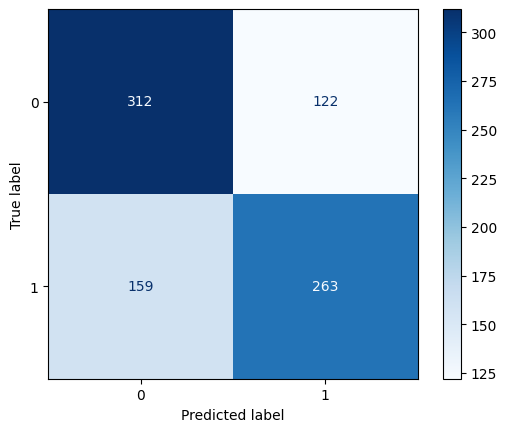

['pre:', 0.6831168831168831, 'recall:', 0.6232227488151659]


In [27]:
y_test, y_pred = y_test.cpu(), y_pred.cpu()
cm = confusion_matrix(y_test, y_pred)

# 显示混淆矩阵
disp = ConfusionMatrixDisplay(confusion_matrix = cm)
disp.plot(cmap = plt.cm.Blues)
plt.show()
## 计算Recall、pre
precision = precision_score(y_test, y_pred, pos_label = 1) # 指定阳性样本（正样本）
recall = recall_score(y_test, y_pred, pos_label = 1)
print([f"pre:", precision, f"recall:", recall])
